<a href="https://colab.research.google.com/github/flxhrdyn/CNN-Mango-Leaf-Disease-Classification/blob/main/CNN_Mango_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import os
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Download Dataset

In [2]:
!gdown --fuzzy https://drive.google.com/file/d/1li3lNOB_Hx2LDjhaT79GCF3JRcbSegnT/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1li3lNOB_Hx2LDjhaT79GCF3JRcbSegnT
From (redirected): https://drive.google.com/uc?id=1li3lNOB_Hx2LDjhaT79GCF3JRcbSegnT&confirm=t&uuid=5b390a07-d6df-471e-a1f8-0f0ff7829be7
To: /content/mango_leaf_disease_dataset_pi.zip
100% 48.6M/48.6M [00:03<00:00, 15.8MB/s]


# Extract Dataset

In [3]:
import zipfile

# extract the dataset
zip_ref = zipfile.ZipFile("/content/mango_leaf_disease_dataset_pi.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Shuffle & Resize Data

In [4]:
DATASET_DIR = "./tmp/mango_leaf_disease_dataset_pi"
IMG_SIZE = 224
BATCH_SIZE = 32

# shuffle and resize data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

# print image classes
img_class = dataset.class_names
img_class

Found 2000 files belonging to 4 classes.


['anthracnose', 'bacterial_canker', 'healthy', 'powdery_mildew']

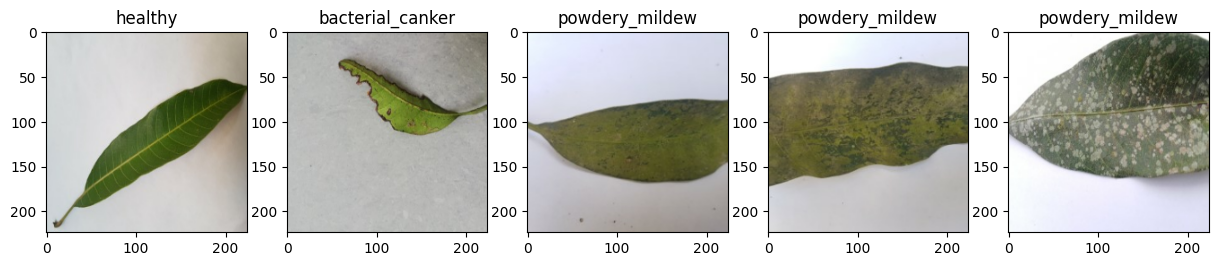

In [5]:
# Take  sample image
plt.figure(figsize=(15, 5))
for img, label in dataset.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(img_class[label[i]]);
    # plt.axis("off")

# Data Splitting

In [6]:
# create a function for splitting dataset
def split_dataset(ds, train_split_size, val_split_size, test_split_size):
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=2000, seed=24)

  # Calculate train, validation, and test set size
  train_set_size = int(len(ds) * train_split_size)
  val_set_size = int(len(ds) * val_split_size)
  test_set_size = int(len(ds) * test_split_size)

  # Split the dataset
  train_set = ds.take(train_set_size)
  validation_set = ds.skip(train_set_size).take(val_set_size)
  test_set = ds.skip(train_set_size).skip(val_set_size)

  return train_set, validation_set, test_set

In [7]:
# splitting dataset to 80% train and 20% validation
train_set, validation_set, test_set = split_dataset(ds=dataset, train_split_size=0.8, val_split_size=0.1, test_split_size=0.1)

print(f"dataset size : {len(dataset)*BATCH_SIZE}")
print(f"training set size : {len(train_set)*BATCH_SIZE}")
print(f"validation set size : {len(validation_set)*BATCH_SIZE}")
print(f"test set size : {len(test_set)*BATCH_SIZE}")

dataset size : 2016
training set size : 1600
validation set size : 192
test set size : 224


# Data Augmentation

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255.0)
])

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# CNN Model 1 (4 Layers)

## 1. Model Architecture

In [10]:
model_1 = models.Sequential([
    # Applying data augmentation
    resize_and_rescale,
    data_augmentation,
    # Convolution and Max pooling layers
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (4, 4), activation="relu"),
    layers.MaxPooling2D(3, 3),
    # Flatten layer
    layers.Flatten(),
    # Fully Connected layer
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")
])
model_1.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 32)          0         
 g2D)                                                 

## 2. Compiling Model

In [11]:
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

## 3. Training Model

In [12]:
EPOCHS = 20
history_model_1 = model_1.fit(train_set,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data = validation_set,
                      verbose = 2)

Epoch 1/20
50/50 - 18s - loss: 1.3390 - accuracy: 0.3251 - val_loss: 0.9718 - val_accuracy: 0.6198 - 18s/epoch - 353ms/step
Epoch 2/20
50/50 - 7s - loss: 1.0193 - accuracy: 0.5158 - val_loss: 0.7902 - val_accuracy: 0.6420 - 7s/epoch - 137ms/step
Epoch 3/20
50/50 - 7s - loss: 0.8230 - accuracy: 0.6136 - val_loss: 0.6640 - val_accuracy: 0.7031 - 7s/epoch - 134ms/step
Epoch 4/20
50/50 - 6s - loss: 0.6589 - accuracy: 0.7013 - val_loss: 0.3879 - val_accuracy: 0.8021 - 6s/epoch - 116ms/step
Epoch 5/20
50/50 - 6s - loss: 0.5577 - accuracy: 0.7904 - val_loss: 0.5112 - val_accuracy: 0.8438 - 6s/epoch - 118ms/step
Epoch 6/20
50/50 - 7s - loss: 0.4317 - accuracy: 0.8295 - val_loss: 0.2498 - val_accuracy: 0.9271 - 7s/epoch - 133ms/step
Epoch 7/20
50/50 - 6s - loss: 0.3431 - accuracy: 0.8788 - val_loss: 0.1896 - val_accuracy: 0.9261 - 6s/epoch - 124ms/step
Epoch 8/20
50/50 - 9s - loss: 0.3698 - accuracy: 0.8573 - val_loss: 0.3552 - val_accuracy: 0.8333 - 9s/epoch - 177ms/step
Epoch 9/20
50/50 - 7s 

## 4. Plot Model's Accuracy and Loss

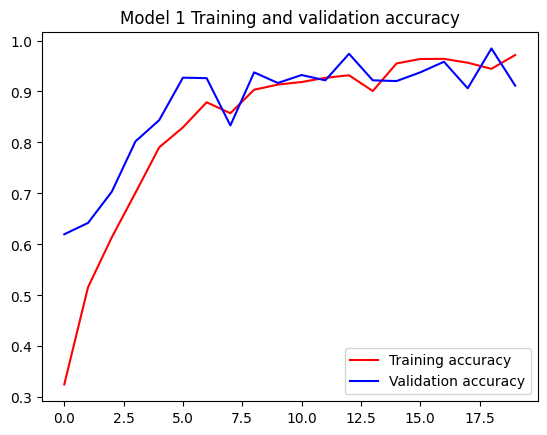

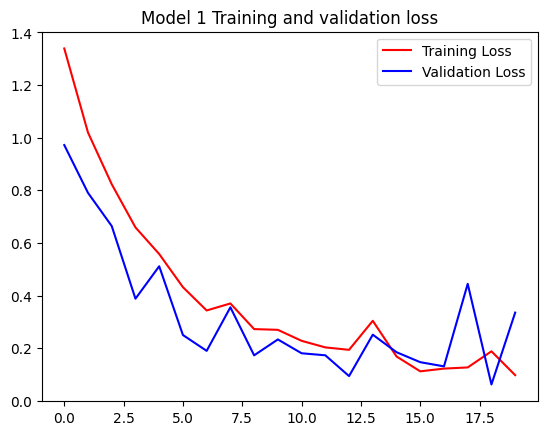

In [13]:
# Plot the results
acc = history_model_1.history['accuracy']
val_acc = history_model_1.history['val_accuracy']
loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']

epochs = range(len(acc))

# accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Model 1 Training and validation accuracy')
plt.legend()

plt.figure()

# loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Model 1 Training and validation loss')
plt.legend()

plt.show()

# CNN Model 2 (6 Layer)

## 1. Model Architecture

In [14]:
model_2 = models.Sequential([
    # Applying data augmentation
    resize_and_rescale,
    data_augmentation,
    # Convolution and Max pooling layers
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(2, 2),
    # Flatten layer
    layers.Flatten(),
    # Fully Connected layer
    layers.Dense(256, activation="relu"),
    layers.Dense(4, activation="softmax")
])
model_2.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 111, 111, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                 

## 2. Compiling Model

In [15]:
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

## 3. Training Model

In [16]:
EPOCHS = 20
history_model_2 = model_2.fit(train_set,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data = validation_set,
                      verbose = 2)


Epoch 1/20
50/50 - 12s - loss: 1.2886 - accuracy: 0.3460 - val_loss: 0.9319 - val_accuracy: 0.5365 - 12s/epoch - 234ms/step
Epoch 2/20
50/50 - 6s - loss: 0.8149 - accuracy: 0.5764 - val_loss: 0.7427 - val_accuracy: 0.5260 - 6s/epoch - 122ms/step
Epoch 3/20
50/50 - 6s - loss: 0.7278 - accuracy: 0.6029 - val_loss: 0.6632 - val_accuracy: 0.6146 - 6s/epoch - 123ms/step
Epoch 4/20
50/50 - 6s - loss: 0.6641 - accuracy: 0.6594 - val_loss: 0.6078 - val_accuracy: 0.7102 - 6s/epoch - 120ms/step
Epoch 5/20
50/50 - 6s - loss: 0.6335 - accuracy: 0.7064 - val_loss: 0.8378 - val_accuracy: 0.6406 - 6s/epoch - 130ms/step
Epoch 6/20
50/50 - 6s - loss: 0.5754 - accuracy: 0.7292 - val_loss: 0.5221 - val_accuracy: 0.7656 - 6s/epoch - 111ms/step
Epoch 7/20
50/50 - 7s - loss: 0.4981 - accuracy: 0.7740 - val_loss: 0.3285 - val_accuracy: 0.8750 - 7s/epoch - 135ms/step
Epoch 8/20
50/50 - 6s - loss: 0.3771 - accuracy: 0.8497 - val_loss: 0.3307 - val_accuracy: 0.8906 - 6s/epoch - 121ms/step
Epoch 9/20
50/50 - 7s 

## 4. Plot Model's Accuracy and Loss


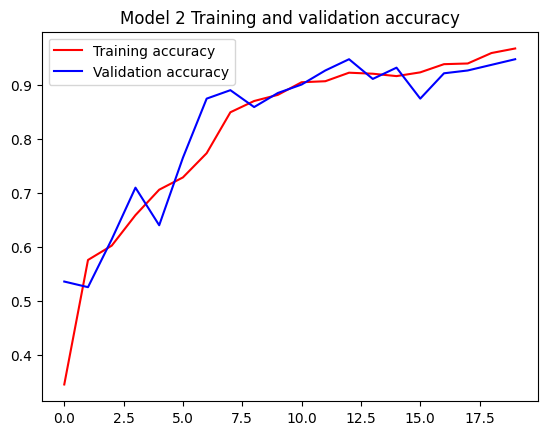

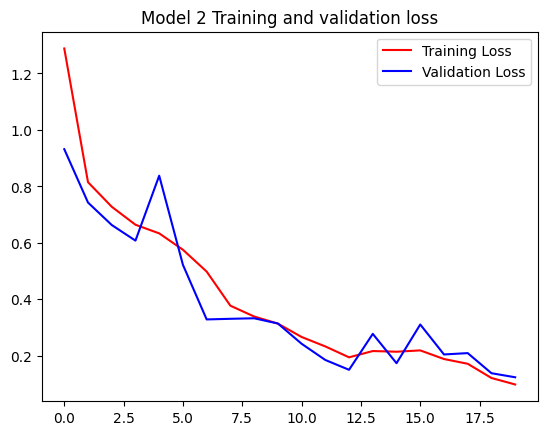

In [17]:
# Plot the results
acc = history_model_2.history['accuracy']
val_acc = history_model_2.history['val_accuracy']
loss = history_model_2.history['loss']
val_loss = history_model_2.history['val_loss']

epochs = range(len(acc))

# accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Model 2 Training and validation accuracy')
plt.legend()

plt.figure()

# loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Model 2 Training and validation loss')
plt.legend()

plt.show()

# Testing the Model

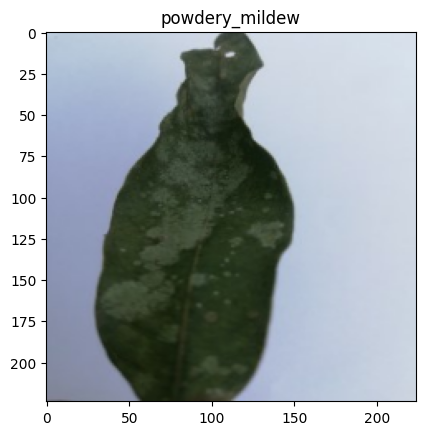

1/1 [==============================] - 0s 29ms/step
True class: powdery_mildew
Predicted class: powdery_mildew


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Take image from test set
for img, label in test_set.take(1):
    first_img = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()

    plt.imshow(first_img)  # Display the first image in the batch
    plt.title(img_class[first_label])
    plt.show()

    prediction = model_2.predict(img)
    predicted_label = np.argmax(prediction, axis=-1)[0]
    predicted_class = img_class[predicted_label]

    true_label = img_class[first_label]

    print(f"True class: {true_label}")
    print(f"Predicted class: {predicted_class}")

    # # Calculate accuracy
    # accuracy = np.argmax(prediction, axis=-1)[0]
    # accuracy_percent = accuracy * 100
    # print(f"Accuracy: {accuracy_percent:.2f}%")

In [19]:
# import numpy as np
# from google.colab import files
# from tensorflow.keras.utils import load_img, img_to_array

# # Define your class labels
# class_labels = ['anthracnose', 'bacterial_canker', 'healthy', 'powdery_mildew']

# uploaded = files.upload()

# for fn in uploaded.keys():
#     # predicting images
#     path = fn
#     img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
#     x = img_to_array(img)
#     x = np.expand_dims(x, axis=0)

#     images = np.vstack([x])
#     classes = model_1.predict(images, batch_size=BATCH_SIZE)

#     # Get the index of the class with the highest probability
#     predicted_class_idx = np.argmax(classes, axis=-1)[0]
#     predicted_class_label = class_labels[predicted_class_idx]

#     print(fn)
#     print(f"Predicted class: {img_class}")
#     print(f"Class probabilities: {classes}")